In [104]:
import numpy as np

### Simulation variables
h=1 # radius of particle
n=10 # number of particles in the cubic lattice
D=2 # number of dimensions
L=10 # length of cube
steps=100
rho0=1
c2=1E16
gamma=7
H=.1

### Dependant variables
sg=h/4 # variance normal distribution
N=n**D # total number of particles for now started in a cibic lattice
A=1/(2*np.pi*sg**2) #normalisation constant
V=L**D/N

In [105]:
import numpy as np
def r(x):
    """Returns the norm of the vector x."""
    return np.linalg.norm(x)

def PosCheck(x,v,D,n,L,i):
    """Poscheck() checks if one of n particles in D dimensions moves out of the box of size L, at timestep i and places it at the other side."""
    for d in range (D):
        for n in range(N):
            if x[i,d,n]>L:
                v[i,d,n]=-v[i,d,n]
            elif x[i,d,n]<0:
                v[i,d,n]=-v[i,d,n]

def PartinRad(x,y,t,dist,N): #check if particles are in a certain radius of a point, x is the dataset, y the checked position/particle
    inrad=np.zeros([D+1,N],dtype=float)
    count =0
    for i in range(N):     #maybe add self exclusion
        a=r(x[t,:,i]-y)
        if a<dist:
            inrad[0:2,count]=x[t,:,i]
            inrad[2,count]=a                        #x,y,r
            count=count+1
    inrad = inrad[:,1:count]
    return inrad                                   #returns matrix x values in range
                
def W(r,sg):                                      #Kernel
    return A*np.exp(-r**2/(2*sg**2))

def gradW(r,sg):                                  #gradient Kernel
    return -r/(sg**2)*W(r,sg)

def Initialize2D(): # initialize 2D with a cubic lattice.
    x=np.zeros([steps,D,N],dtype=float)
    v=np.zeros([steps,D,N],dtype=float)
    rho=np.ones([steps,N],dtype=float)
    P=np.ones([steps,N],dtype=float)
    a=np.ones([N],dtype=float)
    for i in range(n):
        for j in range(n):
            x[0,0,n*i+j]=i/n*L
            x[0,1,n*i+j]=j/n*L
    x[0,:,:]=x[0,:,:]+0.5
    v[0,:,:]=.01*(-1+2*np.random.rand(D,N))
    return x,v,rho,P,a

def PosStep(x,v,rho,P,N,step,H):
    x[i+1,:,:]=x[i,:,:]+v[i,:,:]*H 

def VelStep(x,v,rho,P,N,step,H):
    for n in range(N):
        p=np.zeros([2,N],dtype=float)
        p[:,:]=x[step,:,:]
        p[0,:]=p[0,:]-x[step,0,n]
        p[1,:]=p[1,:]-x[step,1,n]
        v[step+1,:,n]=v[step,:,n]-H*np.sum(rho[step,:]*V*(P[step,:]/rho[step,:]**2+P[step,n]/rho[step,n]**2)*gradW(np.linalg.norm(p),sg)*p/np.linalg.norm(p))  

def RhoStep(x,v,rho,P,N,step,H):
    for n in range(N):
        q=np.zeros([2,N],dtype=float)
        q[:]=v[step,:,:]
        q[0,:]=q[0,:]-v[step,0,n]
        q[1,:]=q[1,:]-v[step,1,n]
        p=np.zeros([2,N],dtype=float)
        p[:,:]=x[step,:,:]
        p[0,:]=p[0,:]-x[step,0,n]
        p[1,:]=p[1,:]-x[step,1,n]
        rho[step+1,n]=rho[step,n]+H*np.sum(rho[step,:]*V*(q)*gradW(np.linalg.norm(p),sg)*p/np.linalg.norm(p))
        
def PStep(x,v,rho,P,N,step,H):
    for i in range(N):
        P[step+1,i]=rho0*c2/gamma*((rho[step,i]/rho0)**gamma-1)
        
        
def visc(a,c,h):
    return (a*c*h)/8

def PIij(x,v,rho,a,c,h,step):
    PI=np.zeros([1,N],dtype=float)
    vis=visc(a,c,h)
    for i in range (N):
        Pi=np.zeros([1,N],dtype=float)
        for j in range (N):
            if (i!=j):
                P1=-16*vis[i]*vis[j]/(rho[step,i]*vis[i]+rho[step,j]*vis[j])
                P2=np.dot((v[step,:,i]-v[step,:,j]),(x[0,:,i]-x[0,:,j]))/(2*h*r(x[0,:,i]-x[0,:,j]))
                Pi[0,j]=P1*P2
    PI[0,i]=np.sum(Pi)
    return PI


In [114]:
### Initialise
x,v,rho,P,a=Initialize2D()
print(type(x))
for i in range(steps-1):
    i2=int(i/2)                                 # Pot&Kin only updated after a whole Leapfrog step
    if i%2==0:
        x[i+1,:,:]=x[i,:,:]                     # Leapfrog 1/2 step, use old position 
        VelStep(x,v,rho,P,N,i,H)
        rho[i+1,:]=rho[i,:]
        PosCheck(x,v,D,n,L,i)                   # check if particles have moved outside the box, if so: move to other side
            
    else:
        RhoStep(x,v,rho,P,N,i,H)
        PosStep(x,v,rho,P,N,i,H)          # calculate new position, from old position + velocity * h  
        PStep(x,v,rho,P,N,i,H)
        v[i+1,:,:] = v[i,:,:]                   # use old velocity                                                              
    if (i+2)/steps*100%10==0:
        print((i+2)/steps*100,'%')              # print the progress
print(type(rho))

<class 'numpy.ndarray'>
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
<class 'numpy.ndarray'>


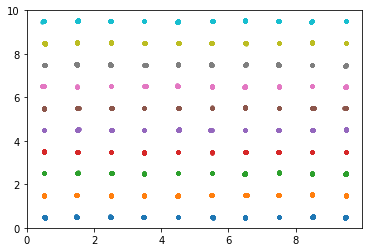

<Figure size 432x288 with 0 Axes>

In [107]:
import matplotlib.pyplot as plt
for i in range(N):
    plt.plot(x[:,0,i],x[:,1,i],linestyle="",marker=".")
plt.show()
plt.savefig('trajectories.eps')

numpy.ndarray